In [1]:
import os
import math
import numpy as np
import torch
import tqdm
import sys
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

from mydataset import MyDataSet
from utils import read_split_data
from model import BetaVAE
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
import sklearn
from sklearn.cluster import KMeans


/Users/tanx/opt/anaconda3/envs/etna_torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()
tb_writer = SummaryWriter()
device = torch.device(args.device if torch.cuda.is_available() else "cpu")

In [3]:
batch_size = 1
lrm = 0.002
lrf = 0.000001
epochs = 100

label = np.load("../MicSigV1_jsn/MicSigV1/label4.npy")
spec = np.load("../MicSigV1_jsn/MicSigV1/spec4.npy")
waveform = np.load("../MicSigV1_jsn/MicSigV1/waveform4.npy")

test_label = np.load("../MicSigV1_jsn/MicSigV1/test_label.npy")
test_spec = np.load("../MicSigV1_jsn/MicSigV1/test_spec.npy")
test_waveform = np.load("../MicSigV1_jsn/MicSigV1/test_waveform.npy")


idx=(np.squeeze(np.where(test_label==3)))
idx=np.concatenate((idx,np.squeeze(np.where(test_label==4))))
idx=np.concatenate((idx,np.squeeze(np.where(test_label==5))))
# idx = np.array(idx)
test_label = test_label[idx]
test_spec = test_spec[idx]
test_waveform = test_waveform[idx]

tensor_label = torch.Tensor(label)
tensor_spec = torch.Tensor(spec)
tensor_spec = torch.unsqueeze(tensor_spec,dim=1)
tensor_waveform = torch.Tensor(waveform)

test_tensor_label = torch.Tensor(test_label)
test_tensor_spec = torch.Tensor(test_spec)
test_tensor_spec = torch.unsqueeze(test_tensor_spec,dim=1)
test_tensor_waveform = torch.Tensor(test_waveform)

train_dataset = TensorDataset(tensor_spec,tensor_label)
test_dataset = TensorDataset(test_tensor_spec,test_tensor_label)

In [4]:
test_label.shape

(11720,)

In [5]:
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 4])  # number of workers
print('Using {} dataloader workers every process'.format(nw))

Using 0 dataloader workers every process


In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=False,
                                           pin_memory=True,
                                           num_workers=nw)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False,
                                           pin_memory=True,
                                           num_workers=nw)


In [8]:
model = BetaVAE(in_channels = 1,
                latent_dim = 20,
                hidden_dims = [4, 8, 16, 32],
                loss_type = 'H',
                input_size=(32,64))
model.load_state_dict(torch.load('./weights/BEST_model_3264_aug_100_latent20_AE-99.pth'))
# summary(model, (1, 32, 64))

<All keys matched successfully>

In [9]:
def eval_one_epoch(model, data_loader, device, epoch):
    mus = []
    log_vars = []
    labels = []
    sample_num = 0
    data_loader = tqdm(data_loader, file=sys.stdout)
    for step, data in enumerate(data_loader):
        image, label = data
        recons, inputs, mu, log_var = model.forward(image)

        labels.append(label.detach().numpy())
        mus.append(mu.detach().numpy())
        log_vars.append(log_var.detach().numpy())

    return labels, mus, log_vars

In [10]:
labels, mus, log_vars = eval_one_epoch(model=model,
                                       data_loader=train_loader,
                                       device=device,
                                       epoch=1)
test_labels, test_mus, test_log_vars = eval_one_epoch(model=model,
                                       data_loader=test_loader,
                                       device=device,
                                       epoch=1)

100%|████████████████████████████████████| 11720/11720 [00:58<00:00, 201.90it/s]


In [96]:
labels = np.array(labels)
mus = np.squeeze(np.array(mus))
log_vars = np.squeeze(np.array(log_vars))
mu_var = np.concatenate((mus,log_vars),axis=1)

test_labels = np.array(test_labels).reshape((-1,10))
test_mus = np.squeeze(np.array(test_mus)).reshape((-1,10,20))
test_log_vars = np.squeeze(np.array(test_log_vars)).reshape((-1,10,20))
test_mu_var = np.concatenate((test_mus,test_log_vars),axis=2)

ave_labels = test_labels[:,1]
ave_mu_var = np.average(test_mu_var[:,:6], axis=1)
ave_mus = np.average(test_mus[:,:6], axis=1)
ave_log_vars = np.average(test_log_vars[:,:6], axis=1)

test_labels2 = test_labels[:,1]
test_mu_var2 = test_mu_var[:,1]
test_mus2 = test_mu_var[:,1]
test_log_vars2 = test_log_vars[:,1]

test_labels = np.reshape(test_labels,(-1))
test_mu_var = np.reshape(test_mu_var,(-1,40))
test_mus = np.reshape(test_mus,(-1,20))
test_log_vars = np.reshape(test_log_vars,(-1,20))

In [97]:
# pca_mus = sklearn.decomposition.PCA(n_components=10).fit(log_vars.transpose()+mus.transpose())

In [98]:
# X_embedded = sklearn.manifold.TSNE(n_components=2, 
#                                    learning_rate=100,  
#                                    perplexity=30).fit_transform(pca_mus.components_.transpose())
# X_embedded = sklearn.manifold.TSNE(n_components=2, 
#                                    learning_rate=210, 
#                                    n_iter = 8000,
#                                    perplexity=30).fit_transform(mus)

# test_X_embedded = sklearn.manifold.TSNE(n_components=2, 
#                                    learning_rate=210, 
#                                    n_iter = 8000,
#                                    perplexity=30).fit_transform(test_mus)

# test_X_embedded2 = sklearn.manifold.TSNE(n_components=2, 
#                                    learning_rate=210, 
#                                    n_iter = 8000,
#                                    perplexity=30).fit_transform(test_mus2)

ave_X_embedded = sklearn.manifold.TSNE(n_components=2, 
                                   learning_rate=210, 
                                   n_iter = 8000,
                                   perplexity=30).fit_transform(ave_mus)

/Users/tanx/opt/anaconda3/envs/etna_torch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [99]:
def plot_clusters(labels,X_embedded):
    ones = np.where(labels==1)
    twos = np.where(labels==2)
    threes = np.where(labels==3)
    fours = np.where(labels==4)
    fives = np.where(labels==5)

    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(X_embedded[ones,0],X_embedded[ones,1],color='blue')
    ax.scatter(X_embedded[twos,0],X_embedded[twos,1],color='red')
    ax.scatter(X_embedded[threes,0],X_embedded[threes,1],color='green')
    ax.scatter(X_embedded[fours,0],X_embedded[fours,1],color='purple')
    ax.scatter(X_embedded[fives,0],X_embedded[fives,1],color='orange')
    plt.show()

In [100]:
# plot_clusters(labels, X_embedded)

In [101]:
# plot_clusters(test_labels2, test_X_embedded2)

In [102]:
# plot_clusters(test_labels, test_X_embedded)

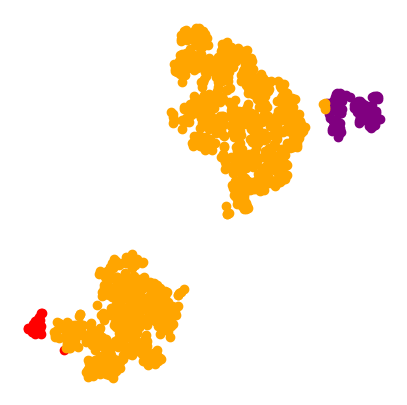

In [103]:
def plot_clusters_pred(labels,X_embedded):
    ones = np.where(labels==1)
    twos = np.where(labels==2)
    threes = np.where(labels==3)
    fours = np.where(labels==4)
    fives = np.where(labels==5)

    fig, ax = plt.subplots(figsize=(5,5))
    ax.scatter(X_embedded[ones,0],X_embedded[ones,1],color='grey')
    ax.scatter(X_embedded[twos,0],X_embedded[twos,1],color='green',label='LP_sub_cluster1')
    ax.scatter(X_embedded[threes,0],X_embedded[threes,1],color='red',label='LP_sub_cluster2')
    ax.scatter(X_embedded[fours,0],X_embedded[fours,1],color='purple',label='REG')
    ax.scatter(X_embedded[fives,0],X_embedded[fives,1],color='orange',label='VT')
    # plt.legend()
    plt.axis('off')
    plt.show()
    
plot_clusters_pred(ave_labels, ave_X_embedded)

In [104]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

nmi = normalized_mutual_info_score
ari = adjusted_rand_score


def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed

    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from scipy.optimize import linear_sum_assignment as linear_assignment
    ind = linear_assignment(w.max() - w)
    a=ind[0]
    b=ind[1]
    
    return sum([w[a[i], b[i]] for i in range(len(a))]) * 1.0 / y_pred.size

In [105]:
# X_embedded = pca_mus.components_.transpose()
# temp_label = np.concatenate((labels[np.where(labels==3)],labels[np.where(labels==5)]))
# # label3 = np.concatenate((temp_label, labels[np.where(labels==5)]))

# temp_embedded = np.concatenate((X_embedded[np.where(labels==3)[0]],X_embedded[np.where(labels==5)[0]]))
# # embedded3 = np.concatenate((temp_embedded, X_embedded[np.where(labels==5)[0]]))

In [106]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, n_init=20)
y_pred = kmeans.fit_predict(ave_mus)

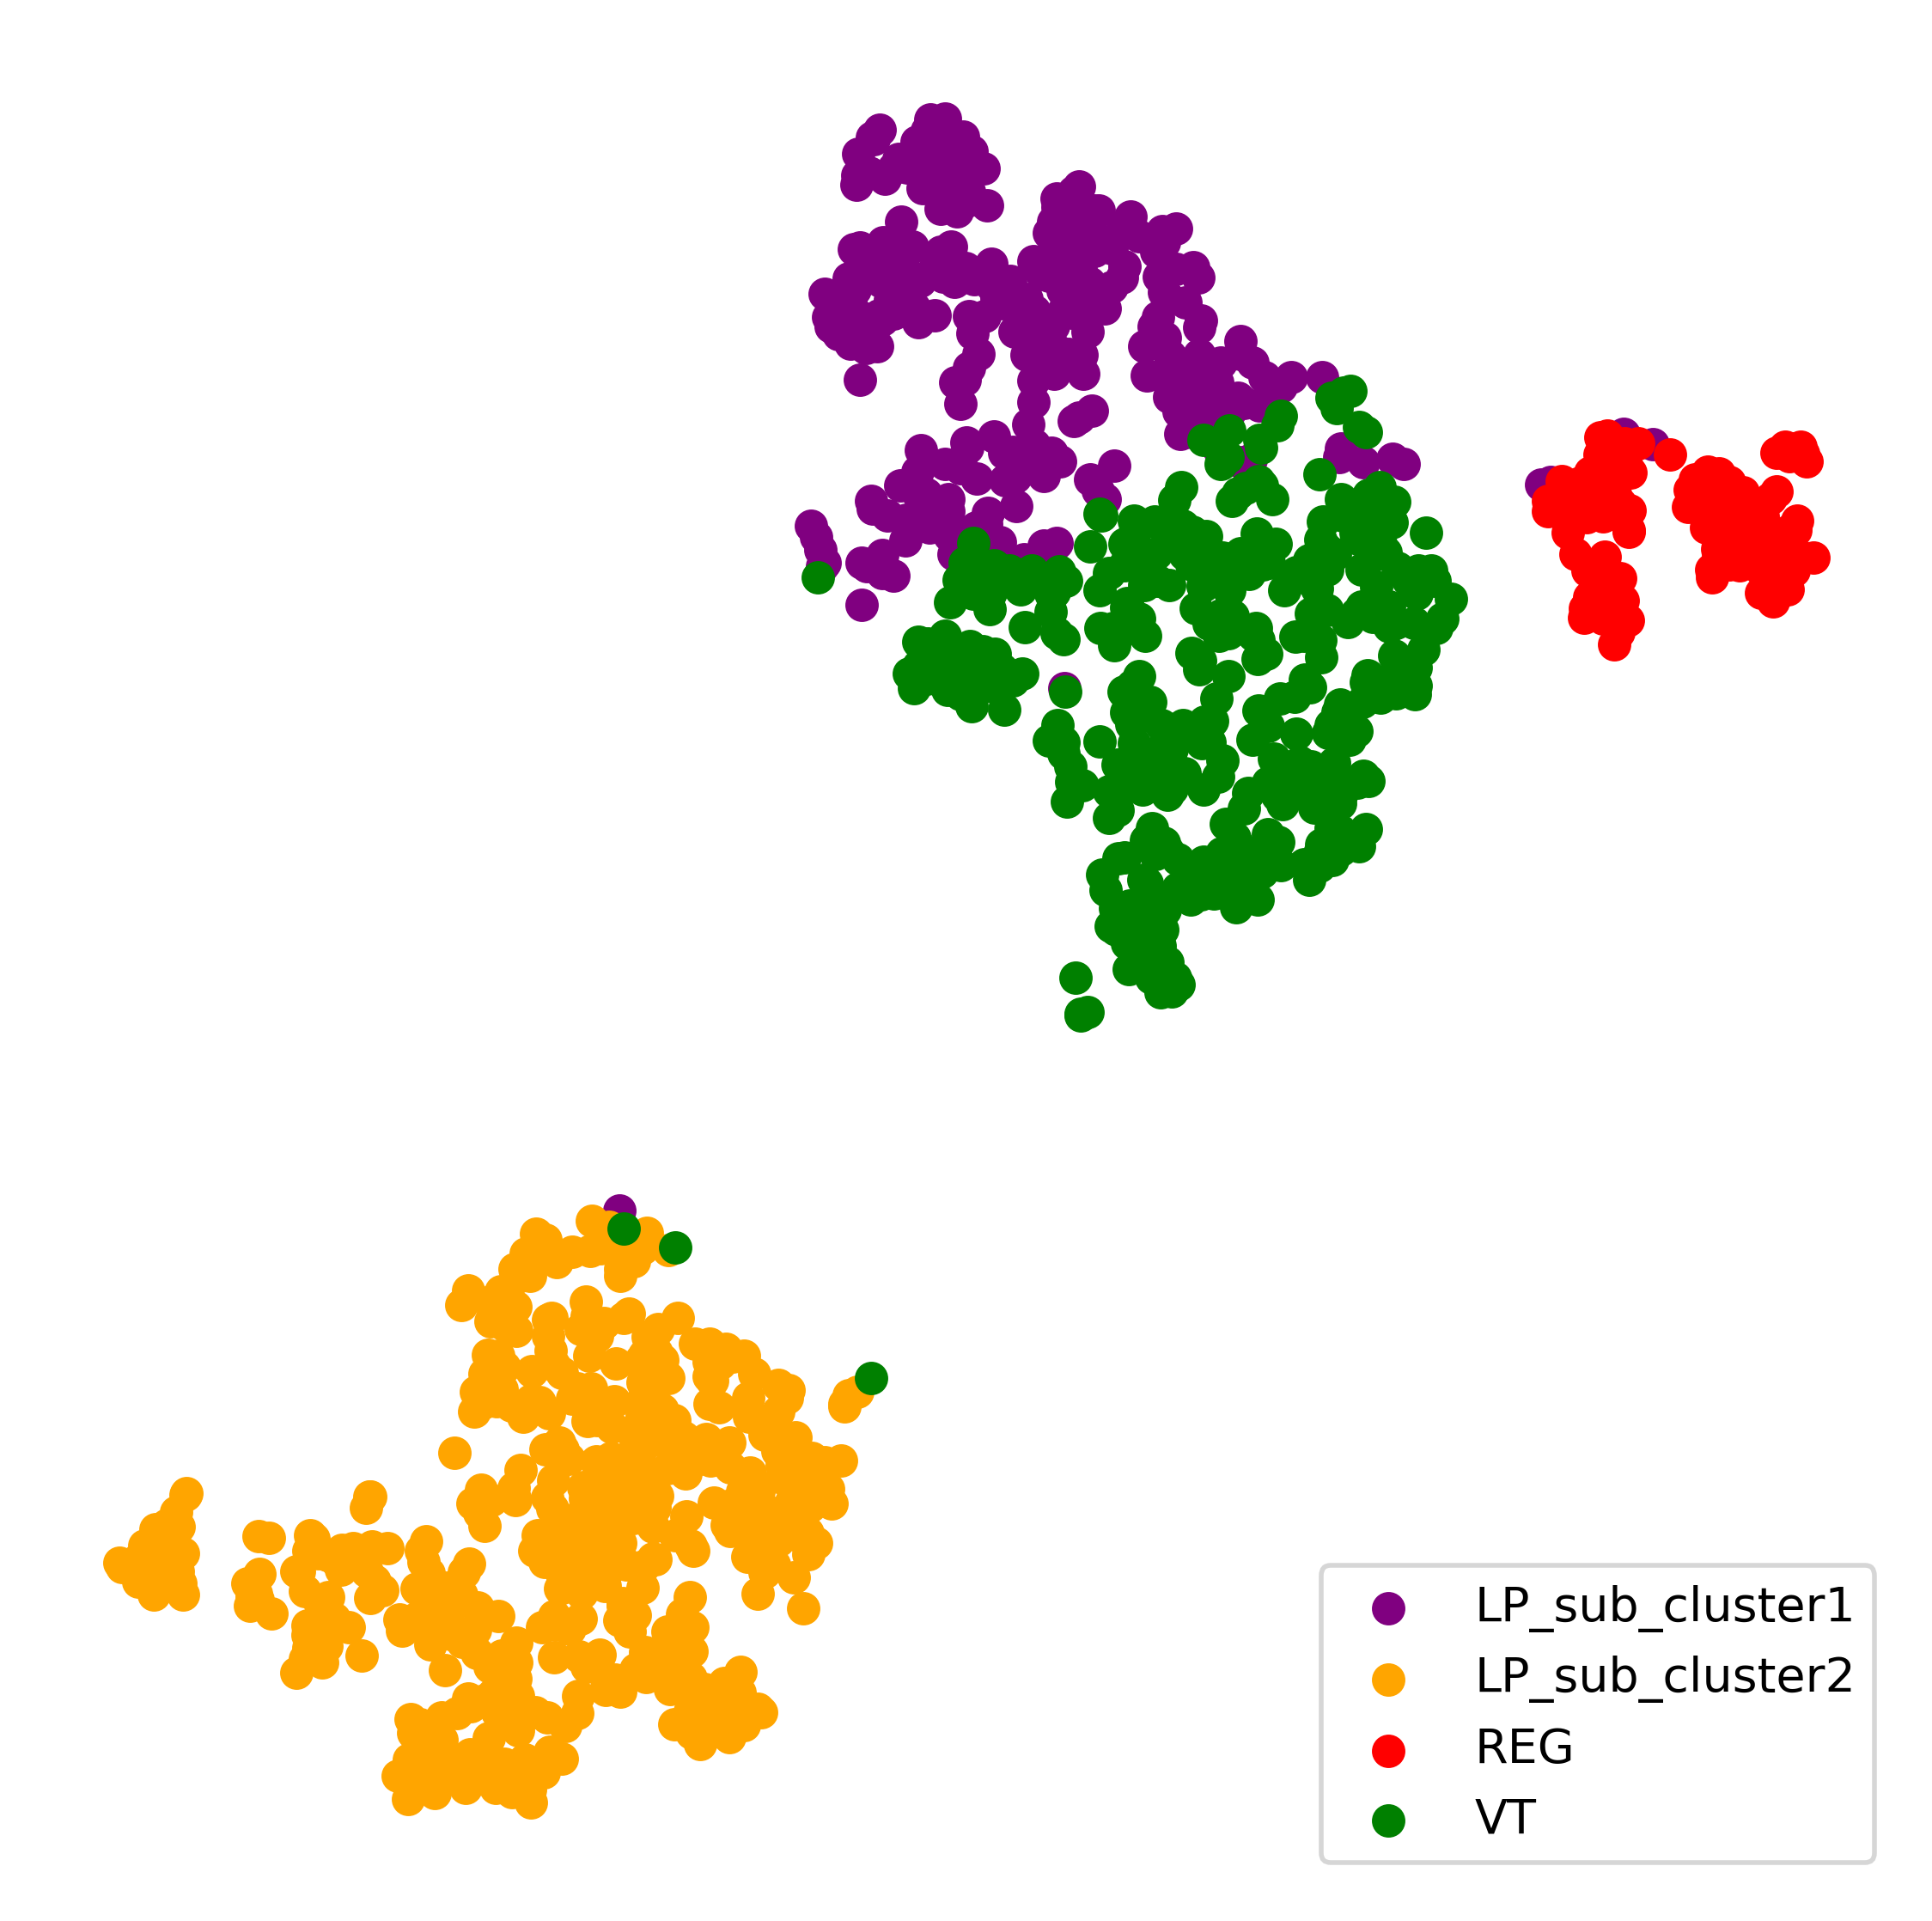

In [111]:
def plot_clusters_pred(labels,X_embedded):
    ones = np.where(labels==1)
    twos = np.where(labels==2)
    threes = np.where(labels==3)
    fours = np.where(labels==4)
    fives = np.where(labels==5)

    fig, ax = plt.subplots(figsize=(7,7),dpi=400)
    ax.scatter(X_embedded[ones,0],X_embedded[ones,1],color='orange')
    ax.scatter(X_embedded[twos,0],X_embedded[twos,1],color='purple',label='LP_sub_cluster1')
    ax.scatter(X_embedded[threes,0],X_embedded[threes,1],color='orange',label='LP_sub_cluster2')
    ax.scatter(X_embedded[fours,0],X_embedded[fours,1],color='red',label='REG')
    ax.scatter(X_embedded[fives,0],X_embedded[fives,1],color='green',label='VT')
    plt.legend(loc='lower right')
    plt.axis('off')
    plt.savefig('new.png')
    plt.show()
    
plot_clusters_pred(y_pred+2, ave_X_embedded)
# plot_clusters(y_pred+2, ave_X_embedded)

In [144]:
min(y_pred)

0

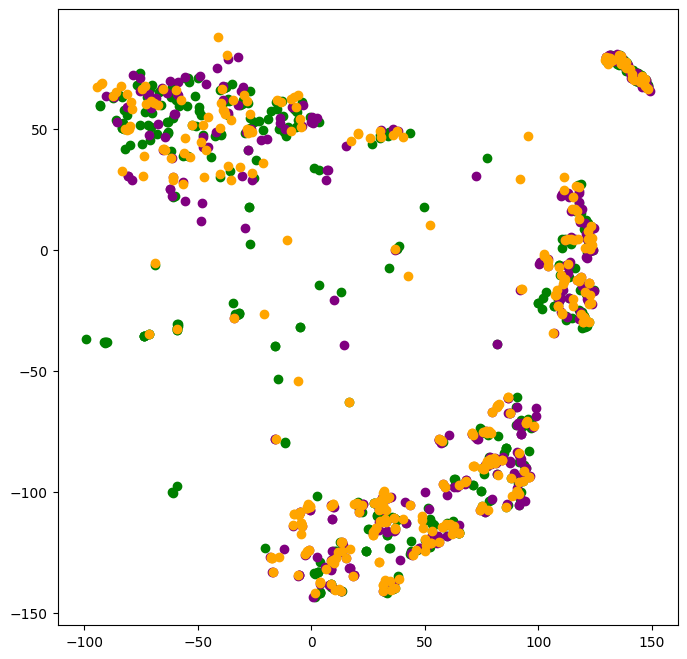

In [145]:
fig, ax = plt.subplots(figsize=(8,8))
colors = ['green', 'purple', 'orange']

# ax.scatter(X_embedded[ones,0],X_embedded[ones,1],color=color)

ax.scatter(X_embedded[np.where(y_pred==0),0],X_embedded[np.where(y_pred==0),1],color='green')
ax.scatter(X_embedded[np.where(y_pred==1),0],X_embedded[np.where(y_pred==1),1],color='purple')
ax.scatter(X_embedded[np.where(y_pred==2),0],X_embedded[np.where(y_pred==2),1],color='orange')
# ax.scatter(X_embedded[ones,0],X_embedded[ones,1],color='red')
# ax.scatter(X_embedded[twos,0],X_embedded[twos,1],color='blue')
# ax.scatter(X_embedded[threes,0],X_embedded[threes,1],color='green')
# ax.scatter(X_embedded[fours,0],X_embedded[fours,1],color='purple')
# ax.scatter(X_embedded[fives,0],X_embedded[fives,1],color='orange')